In [1]:
###
import os
os.environ['FINESSE_DIR'] = "/home/haocun.yu/.conda/envs/finesse/bin/"
os.environ['KATINI'] = "/home/haocun.yu/.conda/envs/finesse/bin/kat.ini"
import pykat
import matplotlib.pyplot as pl
from scipy import stats
import numpy as np
# import pandas

%matplotlib inline

                                              ..-
    PyKat 1.1.297         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
kat_code = """

###### Inject Squeezer laser.
l sqz 1u 0 nSQZ 

bs M1_OPO 0 1 0 6 nSQZ dump nM1_OPOc dump
s subM1_OPO 6.35 $nsilica nM1_OPOc nM1_OPO_ARa
bs M1_OPO_AR 0 1 0 6 nM1_OPO_ARa dump nM1_OPO_ARc dump
s lM1_OPO_EDGE 44m nM1_OPO_ARc nOPO_EDGEa
m OPO_EDGE 0 1 0 nOPO_EDGEa nOPO_EDGEb

# edge of OPO block
s lsqz_lens1 0 nOPO_EDGEb nSQZa

lens sqz_lens1 1 nSQZa nSQZb

s lsqz_lens1_faraday 0 nSQZb nSQZc

# 20 mm TGG faraday crystal
m msqz_faraday_a 0 1 0 nSQZc nSQZd
s lsqz_faraday 20m 1.95 nSQZd nSQZe
m msqz_faraday_b 0 1 0 nSQZe nSQZf

s lsqz_faraday_lens2 0 nSQZf nSQZg

lens sqz_lens2 1 nSQZg nSQZh
s lsqz_lens2_zm1 5 nSQZh nZM1a 

bs1 ZM1 800u $Mloss 0 45 nZM1a nZM1b dump dump
s lzm1_zm2 10.0 nZM1b nZM2a

bs1 ZM2 800u $Mloss 0 45 nZM2a nZM2b dump dump
s lzm2_OFI 15.0 nZM2b nOFIout2


###### Start of the Faraday
# Distance from SRM (AR surface) to the input buffle assy (IBA) in OFI sus
s lIBAin 0.491516 nSRMTT2b nIBAin
m1 IBA 1 0 0 nIBAin nIBAout

# Distance from IBA to input of OFI (Prism in between not considered)
s lOFIin 0.16 nIBAout nOFIin

# Input Polirizer IP (Silica)
bs1 IP 1 0 0 0 nOFIin dump nIPtrans dump
s lIP 0.019 $nsilica nIPtrans nROTin

# Rotator (TGG)
m1 ROTin 1 0 0 nROTin nROTb
s lROT 0.08285 $nTGG nROTb nROTouta
m1 ROTout 1 0 0 nROTouta nOPa

# Output polirizer OP (Silica)
s lOP 0.019 $nsilica nOPa nOPb

dbs OPP nOPb nOPc nOPd nOPz

# output port of FI where squeezed field is injected
s lOP2 0 $nsilica nOPc nOPe
m1 mOFIout2 1 0 0 nOPe nOFIout2

s lOP3 0 $nsilica nOPd nOPf
m1 mOPinterface 1 0 0 nOPf nOFIout

# Waveplate thickness 
s lWP 0.0127 $nCalcite nOFIout nWPa
m1 WP 1 0 0 nWPa nWPb

# Distance from Waveplate to OBA of OFI (Prism in between not considered)
s lOBA 0.2098563 nWPb nOBAin
m1 OBA 1 0 0 nOBAin nOBAout


###### Signal recycling mirror 
m1 SRMHR $T_SRM $L_SRM $phi_SRM nSRMHRa nSRMHRb
s SRMsub 0.0749 $nsilica nSRMHRb nSRMARa
m2 SRMAR 50n 0 $phi_SRM nSRMARa nSRMARb
attr SRMHR Rc -5.6938

#Mode-matching telescope counteract lensing.
s lSRMTT1  0 nSRMARb nSRMTT1a
lens SRMTT1 inf  nSRMTT1a nSRMTT1b

s lSRMTT2 0 nSRMTT1b nSRMTT2a 
lens SRMTT2 inf nSRMTT2a nSRMTT2b


##### Path to OMC from OFI
# Distance OBA --> OM1  
s lom1 2.724 nOBAout nOM1a 

#OM1
bs1 OM1 800u $Mloss 0 2.251 nOM1a nOM1b dump dump # T is set for high power; Loss is a guess
attr OM1 Rc 4.6

# Distance OM1 --> OM2
s lom2 1.395 nOM1b nOM2a 

# OM2
bs1 OM2 10u $Mloss 0 4.399 nOM2a nOM2b dump dump  # T is a guess
attr OM2 Rc 1.7058

# Distance OM2 --> OM3
s lom3 0.631 nOM2b nOM3a 
bs1 OM3 10u $Mloss 0 30.037 nOM3a nOM3b nOM3trans dump # T is a guess

# Distance OM3 --> OMC input coupler IC (AR side)
s lom3omc 0.196 nOM3b nOMC_ARIC_in # By design should be ~0.31

###### AS WFSs
# Design T1200410-v2, Page 5, Tab.2
#  Distance measured on Nov 19th, 2018 alog45372,45405
s lOM3trans2ASWFSl 0.6433 nOM3trans nASWFSl101A
lens l101 0.334 nASWFSl101A nASWFSl101B  
s lASWFSlWFSBS 0.06 nASWFSl101B nASWFSBSin
bs ASWFSBS 0.5 0.5 0 45 nASWFSBSin nASWFSBSrefl nASWFSBStrans dump

s lASWFSBS2ASWFSA 0.135 nASWFSBSrefl nASWFSA
attr lASWFSBS2ASWFSA gouy 70

s lASWFSBS2ASWFSB 0.4206 nASWFSBStrans nASWFSB
attr lASWFSBS2ASWFSB gouy 160

###########################################################################
%%% FTend OMCpath 

%%% FTblock OMC
###########################################################################
# OMC (as built parameters: D1300507-v1)

# Input Coupler IC (flat mirror)
bs1 OMC_ARIC 1 0 0 4.004 nOMC_ARIC_in dump nOMC_ARIC_trans dump 
s subOMC_IC 0.01078 $nsilica nOMC_ARIC_trans nOMC_HRIC_in
bs1 OMC_HRIC 0.0076 10u 0 2.7609 nOMC_HRIC_in dump nOMC_HRIC_trans nOMC_HRICret
# Distance from IC to OC 
s OMC_ICOC 0.2815 1 nOMC_HRIC_trans nOMC_HROC_in

# Output Coupler OC (flat mirror)
bs1 OMC_HROC 0.0075 10u 0 4.004 nOMC_HROC_in nOMC_HROC_refl nOMC_HROC_trans nOMC_HROC_ret
s subOMC_OC 0.01078 $nsilica nOMC_HROC_trans nOMC_AROC_in
bs1 OMC_AROC 1 0 0 2.7609 nOMC_AROC_in dump nOMC_AROC_trans dump
# Distance from OC to CM1
s OMC_OCCM1 0.2842 1 nOMC_HROC_refl nOMC_CM1_in

# Curved Mirror CM1
bs1 OMC_CM1 36u 10u 0 4.004 nOMC_CM1_in nOMC_CM1_refl dump dump

# Distance from CM1 to CM2 
s OMC_CM1CM2 0.2815 1 nOMC_CM1_refl nOMC_CM2_in
attr OMC_CM1 Rc 2.57321

# Curved Mirror CM2
bs1 OMC_CM2 35.9u 10u 0 4.004 nOMC_CM2_in nOMC_CM2_refl dump dump
attr OMC_CM2 Rc 2.57369

# Distance from CM2 to IC 
s CM2OC 0.2842 1 nOMC_CM2_refl nOMC_HRICret

cav cavOMC OMC_HROC nOMC_HROC_refl OMC_HROC nOMC_HROC_in

const nsilica 1.44963098985906
const Mloss 37.5u
const T_SRM 0.3234
const L_SRM 8.7u
const nTGG 1.954
const nCalcite 1.65846
const phi_SRM 90.0079280184854

pd OMC_DCPD nOMC_AROC_trans
pd pd_test1 nSRMHRa
pd pd_test2 nSRMTT2b

maxtem 4

yaxis abs

pd AS_A_DC_P nASWFSA
pdtype AS_A_DC_P y-split

pd AS_A_DC_Y nASWFSA
pdtype AS_A_DC_Y x-split

pd AS_B_DC_P nASWFSB
pdtype AS_B_DC_P y-split

pd AS_B_DC_Y nASWFSB
pdtype AS_B_DC_Y x-split
"""

In [3]:
basekat = pykat.finesse.kat() 
basekat.parse(kat_code)

In [29]:
sensors = ['AS_A_DC_P','AS_A_DC_Y','AS_B_DC_P','AS_B_DC_Y']

actuators = ['ZM1','ZM2']

dofs = ['ybeta','xbeta']

act_dofs = ['ZM1_P','ZM1_Y','ZM2_P','ZM2_Y']

out_list = []

for act in range(len(actuators)):
    for i in range(len(dofs)):
        act_commands = """
        xaxis {mname} {dof} lin -2e-6 2e-6 10
        """.format(mname=actuators[act],dof=dofs[i])
        kat = basekat.deepcopy()
        kat.parse(act_commands)
        kat.verbose = False
        out = kat.run()
        out_list.append(out)
        print (actuators[act],dofs[i])
print (out_list[1].x)
print (out_list[1]['AS_A_DC_Y'])
print (out_list[0]['AS_B_DC_P'])

ZM1 ybeta
ZM1 xbeta
ZM2 ybeta
ZM2 xbeta
[-2.0e-06 -1.6e-06 -1.2e-06 -8.0e-07 -4.0e-07  0.0e+00  4.0e-07  8.0e-07
  1.2e-06  1.6e-06  2.0e-06]
[-5.49960699e-13 -4.41569428e-13 -3.32115506e-13 -2.21858867e-13
 -1.11064326e-13  0.00000000e+00  1.11064326e-13  2.21858867e-13
  3.32115506e-13  4.41569428e-13  5.49960699e-13]
[-1.61013735e-13 -1.28947336e-13 -9.67899248e-14 -6.45643956e-14
 -3.22935232e-14  0.00000000e+00  3.22935232e-14  6.45643956e-14
  9.67899248e-14  1.28947336e-13  1.61013735e-13]


In [14]:
def slope_finder(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope

In [39]:
y1AP = slope_finder(out_list[0].x, out_list[0]['AS_A_DC_P'])
y1BP = slope_finder(out_list[0].x, out_list[0]['AS_B_DC_P'])
x1AY = slope_finder(out_list[1].x, out_list[1]['AS_A_DC_Y'])
x1BY = slope_finder(out_list[1].x, out_list[1]['AS_B_DC_Y'])
y2AP = slope_finder(out_list[2].x, out_list[2]['AS_A_DC_P'])
y2BP = slope_finder(out_list[2].x, out_list[2]['AS_B_DC_P'])
x2AY = slope_finder(out_list[3].x, out_list[3]['AS_A_DC_Y'])
x2BY = slope_finder(out_list[3].x, out_list[3]['AS_B_DC_Y'])

In [38]:
print ('       ','ZM1ybeta','ZM1xbeta','ZM2ybeta','ZM2xbeta')
print ('AS_A_DC_P',y1AP,x1AP,y2AP,x2AP)
print ('AS_B_DC_P',y1BP,x1BP,y2BP,x2BP)
print ('AS_A_DC_Y','0',x1AY,y2AY,x2AY)
print ('AS_B_DC_Y','0',x1BY,y2BY,x2BY)

        ZM1ybeta ZM1xbeta ZM2ybeta ZM2xbeta
AS_A_DC_P -1.9719907499376258e-07 2.757822629658493e-07 -1.1261070310718455e-07 -1.5788329239643772e-07
AS_B_DC_P 8.057500501848179e-08 1.2086784332387396e-07 3.946950496165178e-08 -5.985153816138363e-08


NameError: name 'y1AY' is not defined

In [ ]:
act_matrix = pandas.DataFrame(columns=sensors, index=act_dofs)

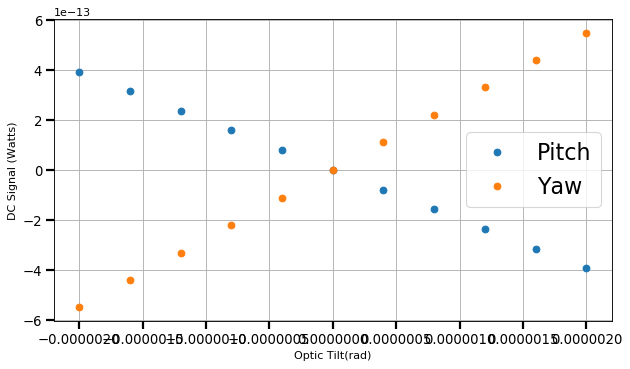

In [80]:
pl.figure(figsize=(9, 5), dpi=80)
pl.subplot(111)

pl.plot(out_list[0].x,out_list[0]['AS_A_DC_P'], 'o',linewidth=3,label='Pitch')
pl.plot(out_list[1].x,out_list[1]['AS_A_DC_Y'], 'o',linewidth=3,label ='Yaw')

pl.xlabel("Optic Tilt(rad)")
pl.ylabel("DC Signal (Watts)")

###Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

No handles with labels found to put in legend.


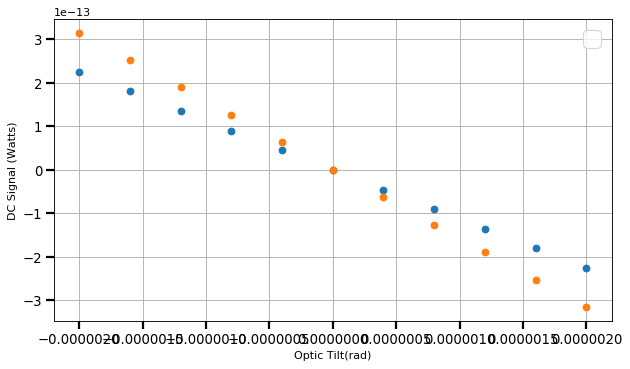

In [81]:
pl.figure(figsize=(9, 5), dpi=80)
pl.subplot(111)

pl.plot(out_list[1].x,out_list[2]['AS_A_DC_P'], 'o',linewidth=3)
pl.plot(out_list[1].x,out_list[3]['AS_A_DC_Y'], 'o',linewidth=3)

pl.xlabel("Optic Tilt(rad)")
pl.ylabel("DC Signal (Watts)")

###Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

In [ ]:
pl.figure(figsize=(9, 5), dpi=80)
pl.subplot(111)

pl.plot(out_list[1].x,out_list[2]['AS_A_DC_P'], 'o',linewidth=3)
pl.plot(out_list[1].x,out_list[3]['AS_A_DC_Y'], 'o',linewidth=3)

pl.xlabel("Optic Tilt(rad)")
pl.ylabel("DC Signal (Watts)")

###Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()